In [1]:
# Image-based microstructure characterization of polymeric foam
# Section one : Image treatment and mesh generation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import ndimage
import os
import pandas as pd
from PIL import Image
from glob import glob

In [2]:
# First Part : import CT image of polymeric foam
files = os.listdir("./")

if "ccf.tif" in files:
    print("Great, the file is found")
else:
    print("Sorry it is missing . Please retry !")

im = Image.open("ccf.tif")

Great, the file is found


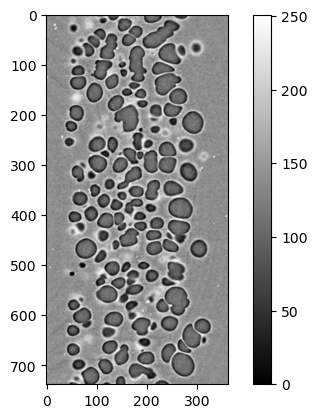

In [3]:
## Part Two : Image treatment 
# Step 1 Sve the image in to numpy array
PP=np.array(im)
fig = plt.figure("Gray scale foam image")
plt.imshow(PP, origin = "upper", cmap = cm.gray)
plt.colorbar()
plt.show()

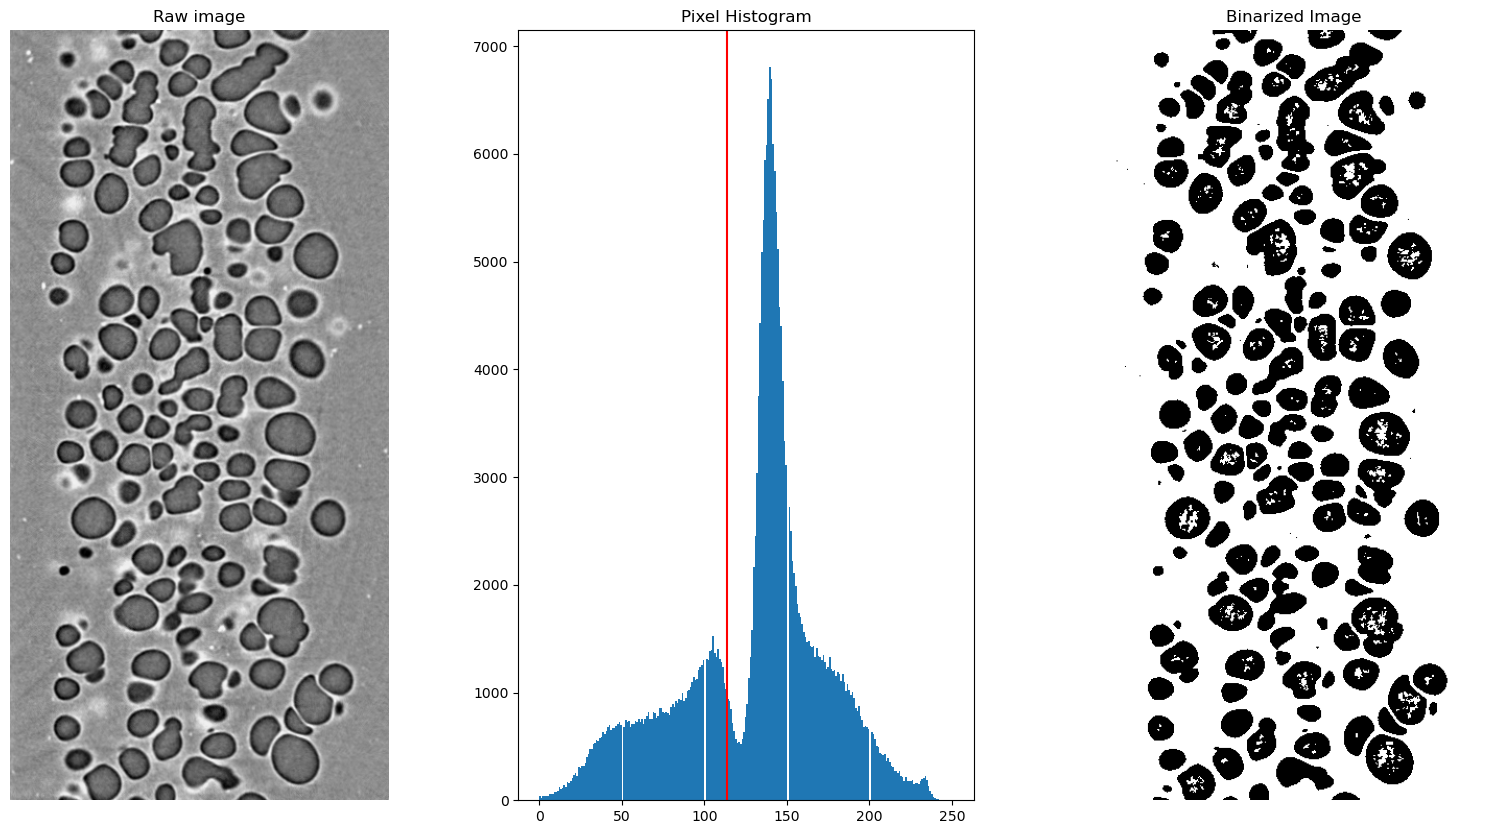

In [4]:
## Step two : Otsu Thresholding of the image
from skimage import data
from skimage.filters import threshold_otsu
thresh = threshold_otsu(PP)
binary = PP > thresh

fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3)

ax[0].imshow(PP, cmap=plt.cm.gray)
ax[0].set_title('Raw image')
ax[0].axis('off')

ax[1].hist(PP.ravel(), bins=256)
ax[1].set_title('Pixel Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Binarized Image')
ax[2].axis('off')

plt.show()

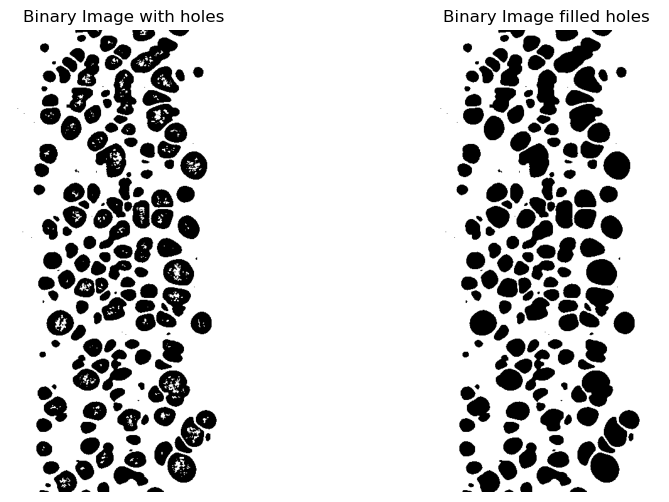

In [5]:
## Step Three : Image patching (fill holes and remove small spots)
from scipy import ndimage
from skimage.morphology import reconstruction
from skimage import morphology

filled = morphology.remove_small_objects(binary, 10000)

fig, axes = plt.subplots(ncols=2, figsize=(10, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)

ax[0].imshow(binary, cmap=plt.cm.gray)
ax[0].set_title('Binary Image with holes')
ax[0].axis('off')

ax[1].imshow(filled,cmap=plt.cm.gray)
ax[1].set_title('Binary Image filled holes')
ax[1].axis('off')

plt.show()

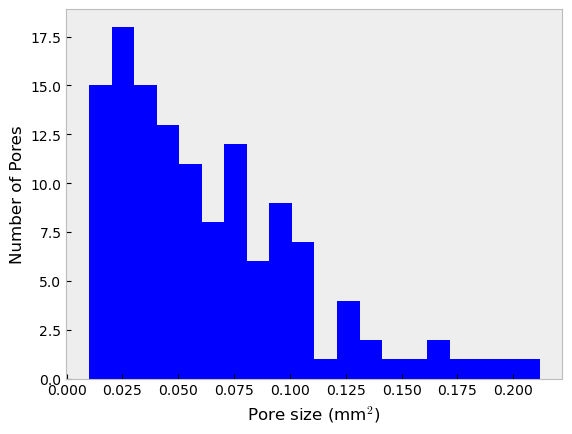

In [6]:
## Step Four : Pore size distribution

from scipy import ndimage

img = filled == 0

# 4 connected component
c=ndimage.generate_binary_structure(2,2)

# Label the pores
labels,n_labels = ndimage.label(img,structure = c)

# Compute the size of each labeled pore
pore_size = ndimage.sum(img,labels,range(n_labels+1))[1:]
n_bin = int(pore_size.max()-1000)


# Resolution of the image
pixel = 0.01 # 1 pixel = 0.01 mm
pore_size = pore_size*pixel**2

# Remove the pore with pixel size equal to 1
sz = (100*pixel**2, pore_size.max())

# Generate the Histogram
his,bin_edge = np.histogram(pore_size,range = sz,bins = 20)
interval = bin_edge[:-1]+bin_edge[1:]
x=0.5*interval
width = x[2] - x[1]

#Plot histogram
with plt.style.context('bmh'):
    plt.bar(x,his,width,color = 'b')
    plt.xlabel('Pore size (mm$^{2}$)')
    plt.ylabel('Number of Pores')
    plt.grid(False)
    plt.show()

    
# Save the data
pore_size = pore_size.reshape(1,164).T

df = pd.DataFrame(pore_size, columns = ['Pore size mm^2'])

df.to_csv('Pore sizes.csv')


In [7]:
## Step five : Mesh generation based on Images
# Save image slices into 3d array
import glob
from PIL import Image

file_list = glob.glob('E:/Codes/CCF/' + '*.tif') # Please specify your file path
print(len(file_list))
foam_vol = []
for i in range(len(file_list)):
    img_foam = Image.open(file_list[i])
    numpydata = np.asarray(img_foam).astype(int)
    foam_vol.append(numpydata)
    
np.save("foam_all.npy", foam_vol)

200


E:\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


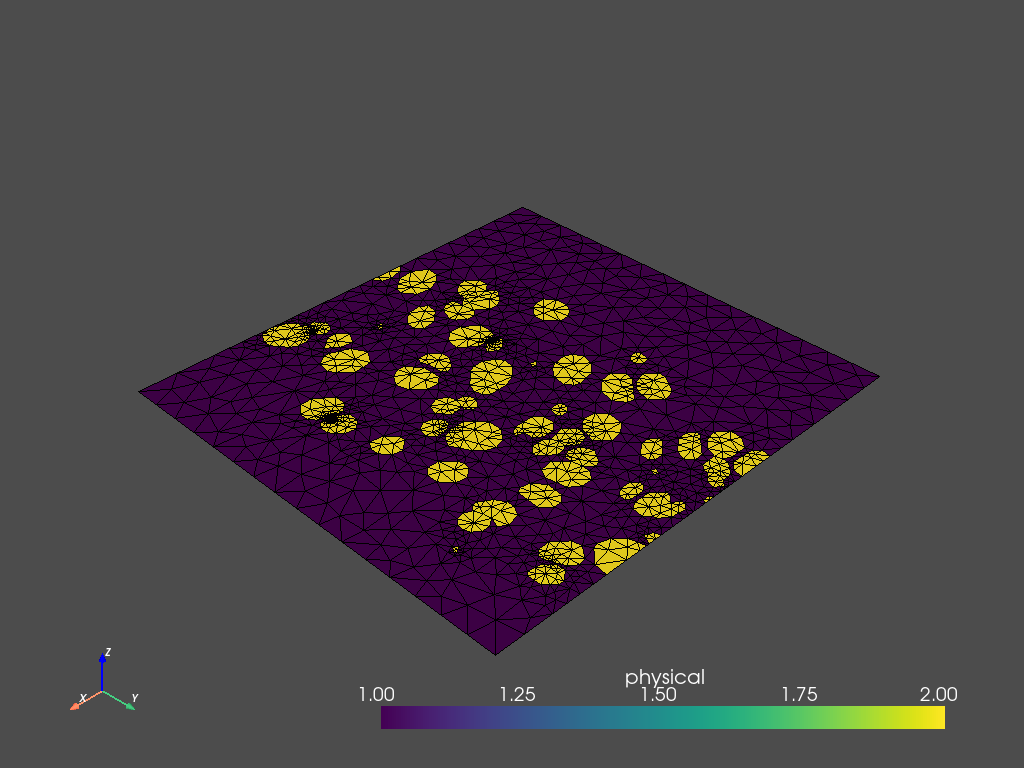

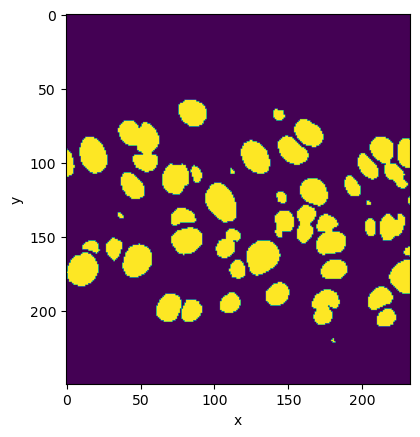

In [8]:
# 2D mesh generation
from nanomesh import Image
from nanomesh.data import nanopores3d
from nanomesh import Mesher2D

data = np.load('foam_all.npy')

vol = Image(data)

plane = vol.select_plane(z=100)

thresh = plane.threshold('mean')

segmented = plane.digitize(bins=[thresh])
segmented.show()

mesher = Mesher2D(plane)
mesher.generate_contour(max_edge_dist=5, level=thresh)
mesh = mesher.triangulate(opts='q30a100')
mesh.plot_pyvista(jupyter_backend='static', show_edges=True)

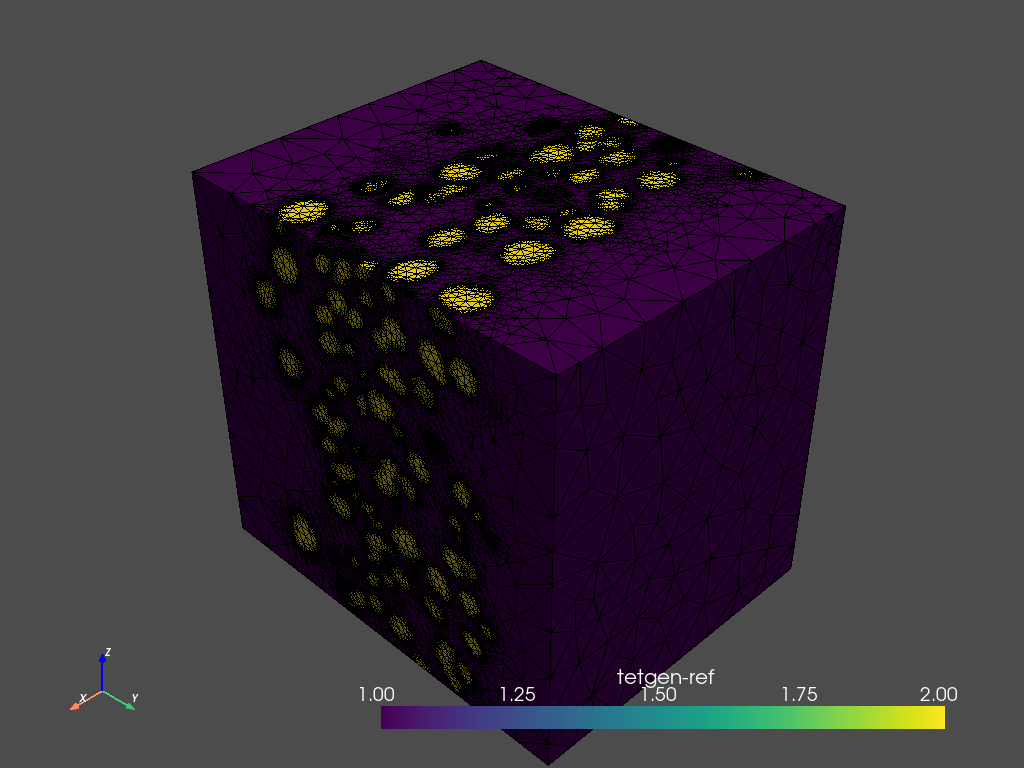

In [9]:
### 3D mesh generation
from nanomesh import Image
from nanomesh.data import nanopores3d
from nanomesh import Mesher

data = np.load('foam_all.npy')

vol = Image(data)

mesher = Mesher(vol)
mesher.generate_contour()
mesh = mesher.tetrahedralize(opts='-pAq')
mesh.plot_pyvista(jupyter_backend='static', show_edges=True)

Results of Uniaxial fitting: 
Q  7.20112924845175
[[Model]]
    Model(Neo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 260
    # variables        = 1
    chi-square         = 201.885486
    reduced chi-square = 0.77948064
    Akaike info crit   = -63.7750594
    Bayesian info crit = -60.2143778
    R-squared          = 0.98338080
[[Variables]]
    c:  8.77722447 +/- 0.02894879 (0.33%) (init = 1)
Results of Uniaxial fitting: 
Q  6.402930436390754
[[Model]]
    Model(Mooney)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 260
    # variables        = 2
    chi-square         = 16.0412089
    reduced chi-square = 0.06217523
    Akaike info crit   = -720.235372
    Bayesian info crit = -713.114009
    R-squared          = 0.99867949
[[Variables]]
    c1:  4.97590731 +/- 0.07000841 (1.41%) (init = 1)
    c2:  5.91779320 +/- 0.10824152 (1.83%) (init = 1)
[[Correlations]] (unrep

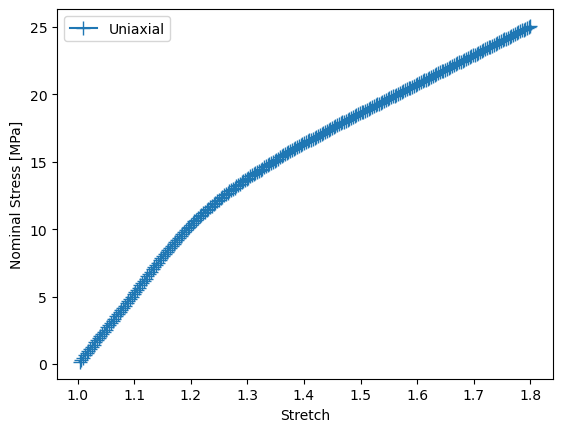

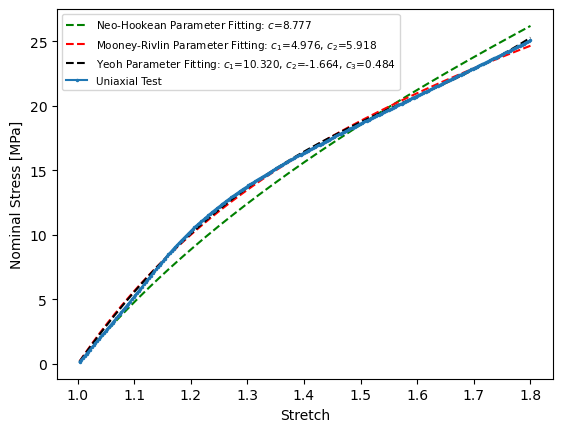

In [10]:
## Step six ： Constitutive equation calibration
# Non-linear curve fitting - Hyperelastic Constitutive Function : Neo-Hookean, Mooney Rivlin, Yeoh(N=3)
import pandas as pd
import math
from matplotlib import pyplot as plt
import numpy as np
import addcopyfighandler
import sympy as sym
from lmfit import Model, Parameters

#Parameters:    
FileName = "data.xlsx"
ms = 10

#Symbols
X = sym.Symbol("X")
Y = sym.Symbol("Y")

#Functions:
def Neo(s,c):
    sigma = 2*c*(s-1/(s**2))
    return sigma

def Mooney(s,c1,c2):
    sigma = 2*c1*(s-1/(s**2))-2*c2*(1/(s**3)-1)
    return sigma

def Yeoh(s,c1,c2,c3):
    sigma = 2*c1*(s-1/(s**2))+4*c2*(s-1/(s**2))*((s**2)+2/s-3)+6*c3*(s-1/(s**2))*(((s**2)+2/s-3)**2)
    return sigma

def RMSRE(exp,sim):
    Q = (1/len(exp) * np.sum(np.divide(np.subtract(exp,sim),exp)**2))**(1/2)*100
    return Q

#Read the measurements
df = pd.read_excel(FileName)
df = df.to_numpy()
s = df[:,0]
ut = df[:,1]

#Tasks:
    
##Task1: Strain-Stress curve of single strut plot
plt.figure(1)
plt.plot(s, ut, marker="+",markersize=ms, label = 'Uniaxial')
plt.xlabel('Stretch', fontsize=10)
plt.ylabel('Nominal Stress [MPa]', fontsize=10)
plt.legend()

##Task2-1: Obtain the material parameters by fitting the model to the uniaxial data using Neo-Hookean
###Model definition:
fmodel = Model(Neo)
###Parameter constrains
params = Parameters()
params.add('c', value=1, vary=True)

###Parameter fitting:
result = fmodel.fit(ut, params, s=s)
popt = [result.values['c']]
Q = RMSRE(ut,Neo(s, *popt))

### Print result
print("Results of Uniaxial fitting: ")
print('Q ',Q)
print(result.fit_report())

##Task2-2: Obtain the material parameters by fitting the model to the uniaxial data using Mooney-Rivlin
###Model definition:
fmodel1 = Model(Mooney)
###Parameter constrains
params1 = Parameters()
params1.add('c1', value=1, vary=True)
params1.add('c2', value=1, vary=True)

###Parameter fitting:
result1 = fmodel1.fit(ut, params1, s=s)
popt1 = [result1.values['c1'],result1.values['c2']]
Q1 = RMSRE(ut,Mooney(s, *popt1))

### Print result
print("Results of Uniaxial fitting: ")
print('Q ',Q1)
print(result1.fit_report())

##Task2-3: Obtain the material parameters by fitting the model to the uniaxial data using Yeoh
###Model definition:
fmodel2 = Model(Yeoh)
###Parameter constrains
params2 = Parameters()
params2.add('c1', value=1, vary=True)
params2.add('c2', value=1, vary=True)
params2.add('c3', value=1, vary=True)

###Parameter fitting:
result2 = fmodel2.fit(ut, params2, s=s)
popt2 = [result2.values['c1'],result2.values['c2'],result2.values['c3']]
Q2 = RMSRE(ut,Yeoh(s, *popt2))

### Print result
print("Results of Uniaxial fitting: ")
print('Q ',Q2)
print(result2.fit_report())

### Plot
plt.figure(2)
plt.plot(s, Neo(s, *popt),'g--',label=r'Neo-Hookean Parameter Fitting: $c$=%5.3f' % tuple(popt))
plt.plot(s, Mooney(s, *popt1),'r--',label=r'Mooney-Rivlin Parameter Fitting: $c_{1}$=%5.3f, $c_{2}$=%5.3f' % tuple(popt1))
plt.plot(s, Yeoh(s, *popt2),'k--',label=r'Yeoh Parameter Fitting: $c_{1}$=%5.3f, $c_{2}$=%5.3f, $c_{3}$=%5.3f' % tuple(popt2))
plt.plot(s, ut, marker=".",markersize=3, label = 'Uniaxial Test')
plt.xlabel('Stretch', fontsize=10)
plt.ylabel('Nominal Stress [MPa]', fontsize=10)
plt.legend(fontsize="7.5",loc='upper left')


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


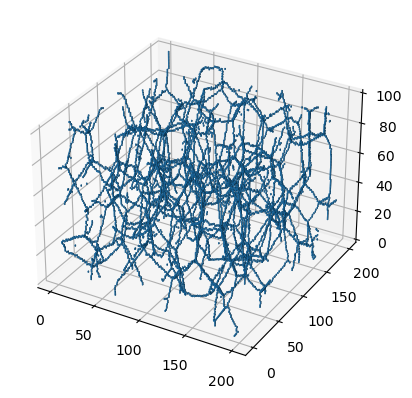

In [11]:
# Section two ： Morphological feature measurement
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, transform, io 
from skimage.measure import label
from scipy import ndimage
from scipy.signal import convolve
import napari

# Read image stack
def read_tiff_stack(file_path):
    im = io.imread(file_path)
    im = im > 0
    im = np.swapaxes(im, 0, 2)
    return im
# Extractio of skeleton
def skeletonize(im):
    skel = morphology.skeletonize_3d(im).astype('bool')
    return(skel)


def distance_transform(im):
    dt = ndimage.distance_transform_edt(im)
    return dt

# Thickness calculation
def calculate_thick(skel, dt, pixel_size):
    thick = skel * dt * 2 / skel.max()
    av = int(np.average(thick[thick>0]))
    av *= 2 # exclude edge pixels that are twice the average
    thick = thick[av:-av, av:-av, av:-av]
    thick = thick[thick>2]
    thick = thick * pixel_size
    return thick


def count_neighbors(skel):
    strel = np.ones((3, 3, 3))
    strel[1, 1, 1] = 0
    conv = convolve(skel, strel, mode='same')
    neighbors = np.round((conv * skel)).astype(np.uint8)
    return neighbors


def find_vertice(neighbors):
    vertice = neighbors > 2
    return vertice


def label_struts(neighbors):
    struts = neighbors < 3
    struts[neighbors == 0] = 0
    labels = label(struts, connectivity=3)
    return labels


def calculate_lengths(labels, pixel_size):
    lengths = np.bincount(labels.flatten())
    lengths[0] = 0 # filter background
    lengths = lengths[lengths>0]
    lengths = lengths * pixel_size
    return lengths

fpath = (r'E:\Codes/foam_opencell.tif')# Please specify your file path

im = read_tiff_stack(fpath)

pixel_size = 0.1

# Skeletonization
skel = skeletonize(im)

# viewer = napari.view_image(skel, contrast_limits=[0, 1])

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(skel)
plt.show()
#Distance map
distance = distance_transform(im)

# Find neighbors: 26-connectivity
neighbors = count_neighbors(skel)

# Find vertex
nodes = find_vertice(neighbors)

# Label the struts
labels = label_struts(neighbors)

# Calculate length
lengths = calculate_lengths(labels * skel, pixel_size)

# Calculate thickness
all_thick = calculate_thick(skel, distance, pixel_size)

# Save the result
def export(path):
    with open(path, 'w') as f:
        f.write('Average of all strut thickness: ')
        f.write(str(round(np.mean(all_thick),2)))
        f.write('\n')
        f.write('Average strut length (vertex to vertex) : ')
        f.write(str(round(np.mean(lengths), 2)))
        f.write('\n')
        f.write('\n\n\n')
        f.write('All thickness measurements')
        f.write('\n')
        f.write('\n'.join([str(round(i,2)) for i in all_thick]))
        f.write('\n\n')
        f.write('\n\n')
        f.write('All length measurements')
        f.write('\n')
        f.write('\n'.join([str(round(i,3)) for i in lengths]))
        f.write('\n\n')

wpath = (r'E:\Codes/result.txt') # Please specify your file path

export(wpath)
